In [169]:
def readfile(path):
    with open(path) as f:
        captions=f.read()
    return captions


In [170]:
captions=readfile(r"datasets\flickr glove dataset\flickr\Flickr8k.token.txt")
captions=captions.split('\n')[:-1]
# captions[0]
print(captions[0])
print(len(captions))


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
40460


In [171]:
first,second=captions[0].split('\t') 
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [172]:
descriptions={}
for i in captions:
    first,second=i.split('\t')
    img_name=first.split(".")[0]

    ## if the image id is already present or not

    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [173]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [174]:
import cv2
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import nltk
from nltk.corpus import stopwords
import string
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [175]:
image_path=r"datasets\flickr glove dataset\Images/"

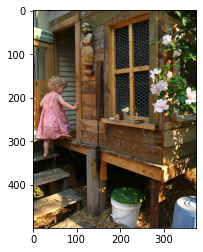

In [176]:

# img = io.imread(image_path+"1000268201_693b08cb0e.jpg")

img=cv2.imread(image_path+"1000268201_693b08cb0e.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


## Data cleaning

In [177]:
import re
import json

In [178]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence

In [179]:
clean_text("A cat is sitting over the house %$754")

'cat is sitting over the house'

In [180]:
# clean all captions

for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])


In [181]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [182]:
# write data to text file

with open("descriptions.txt","w") as f:
    f.write(str(descriptions))


In [184]:
descriptions=None
with open("descriptions.txt","r") as f:
    descriptions=f.read()
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [185]:
print(type(descriptions))

<class 'dict'>


In [186]:
# vocab

vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print(" total unique vocab size : %d"% len(vocab))

 total unique vocab size : 8424


In [187]:
# total number of word across all the sentence

total_words=[]

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("total word %d"%len(total_words))

total word 373837


In [188]:
import collections
counter = collections.Counter(total_words)
freq_cnt=dict(counter)
print(len(freq_cnt.keys()))

8424


In [144]:
freq_cnt

{'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fingerpaints': 3,

In [189]:
# sort this dictionary according to the frequency

sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

#filter

threshold=10

sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt ]

In [190]:
print(len(total_words))

1845


## Prepare Train/Test Data

In [191]:
train_file_data = readfile(r"datasets\flickr glove dataset\flickr\Flickr_8k.trainImages.txt")
test_file_data = readfile(r"datasets\flickr glove dataset\flickr\Flickr_8k.testImages.txt")

In [192]:
print(train_file_data)

52662c30.jpg
3141440149_00becbbb93.jpg
2590207488_ddd89037ba.jpg
2419186511_f0ce5f9685.jpg
3631671718_d712821757.jpg
2741051940_89fb6b2cee.jpg
3303787342_b258b377b6.jpg
160585932_fa6339f248.jpg
1413956047_c826f90c8b.jpg
3656906086_7034f69ab6.jpg
114949897_490ca7eaec.jpg
1511807116_41c3645e8c.jpg
2490365757_b869282cb3.jpg
191003287_2915c11d8e.jpg
2861100960_457ceda7fa.jpg
3321956909_7b5ddf500f.jpg
3168841415_c0705a327a.jpg
2172493537_128bc8b187.jpg
2159447283_fab8c272b0.jpg
2784408839_53a25a21eb.jpg
2836553263_b1a08c25ea.jpg
709373049_15b8b6457a.jpg
241347441_d3dd9b129f.jpg
3175446111_681a89f873.jpg
539761097_5c6c70425b.jpg
2688102742_885e578a3f.jpg
3699318394_6193f2c8e0.jpg
2665264979_df9c284bf8.jpg
3400385314_a5bc062e97.jpg
2075041394_0b3ea1822d.jpg
3490186050_4cb4193d4d.jpg
350529848_9569a3bcbc.jpg
2975807155_5a8610c297.jpg
3174431688_ae84778db0.jpg
3380407617_07b53cbcce.jpg
3248220732_0f173fc197.jpg
2332986053_864db84971.jpg
3258391809_38fc6211f7.jpg
2549452277_873cb80d3e.jpg
327004

In [193]:
train_file_data[-1]

'\n'

In [194]:
train=[row for row in train_file_data.split("\n")[:-1]]
train[:5]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg',
 '488416045_1c6d903fe0.jpg',
 '2644326817_8f45080b87.jpg']

In [195]:
train=[row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [196]:
test=[row for row in test_file_data.split("\n")[:-1]]
test[:5]

['3385593926_d3e9c21170.jpg',
 '2677656448_6b7e7702af.jpg',
 '311146855_0b65fdb169.jpg',
 '1258913059_07c613f7ff.jpg',
 '241347760_d44c8d3a01.jpg']

In [197]:
test=[row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
test[:5]

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01']

# prepare description for training data
   ## Add startseq and endseq

In [198]:
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append= "startseq "+ cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [199]:
# before 
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [200]:
# after
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [298]:
from tensorflow.keras.applications.xception import Xception,preprocess_input,decode_predictions
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,Dropout,Embedding,LSTM
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Transfer learning

## Image --> features
## Text --> features


# Image features extraction

In [201]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]   

In [202]:
model.layers[-2]

In [203]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [204]:
model_new = Model(model.input,model.layers[-2].output)

In [205]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)       # normalisation
    img=preprocess_input(img)
    return img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[[[[ -30.939003   -61.779      -67.68     ]
   [  13.060997     6.2210007  -17.68     ]
   [  34.060997    32.221        5.3199997]
   ...
   [ -99.939     -116.779     -118.68     ]
   [ -98.939     -111.779     -118.68     ]
   [-101.939     -108.779     -120.68     ]]

  [[ -36.939003   -68.779      -72.68     ]
   [  21.060997     9.221001   -13.68     ]
   [  38.060997    37.221        8.32     ]
   ...
   [ -94.939     -104.779     -113.68     ]
   [ -93.939     -108.779     -116.68     ]
   [ -90.939      -86.779     -102.68     ]]

  [[ -39.939003   -74.779      -76.68     ]
   [  26.060997    13.221001    -9.68     ]
   [  41.060997    36.221        6.3199997]
   ...
   [ -99.939     -107.779     -115.68     ]
   [-101.939     -107.779     -121.68     ]
   [ -95.939     -101.779     -123.68     ]]

  ...

  [[ -27.939003    56.221      107.32     ]
   [ -92.939      -4

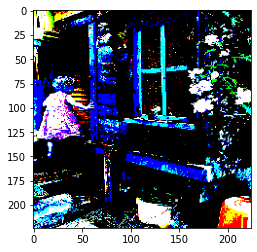

In [206]:
img=preprocess_img(image_path+"1000268201_693b08cb0e.jpg")
# plt.imshow(img[0]/255.0)
print(img)
plt.imshow(img[0])

In [207]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vector= model_new.predict(img)
    feature_vector=feature_vector.reshape((-1))
    # print(feature_vector.shape)
    return feature_vector


In [208]:
encode_img(image_path+"1000268201_693b08cb0e.jpg")

array([0.06536549, 0.16782689, 0.3251846 , ..., 0.0511154 , 0.32817915,
       1.0043331 ], dtype=float32)

## training image encoding

In [209]:
start_time=time()
encoding_train={}

# image_id --> feature_vector extracted from Resnet Image

for i,img_id in enumerate(train):
    img_path= image_path + "/" + img_id + ".jpg"
    encoding_train[img_id] = encode_img(img_path)

    if i%100==0:
        print("encoding in progress time step %d"%i)

end_time=time()
print("total train time taken :" , end_time-start_time)

encoding in progress time step 0
encoding in progress time step 100
encoding in progress time step 200
encoding in progress time step 300
encoding in progress time step 400
encoding in progress time step 500
encoding in progress time step 600
encoding in progress time step 700
encoding in progress time step 800
encoding in progress time step 900
encoding in progress time step 1000
encoding in progress time step 1100
encoding in progress time step 1200
encoding in progress time step 1300
encoding in progress time step 1400
encoding in progress time step 1500
encoding in progress time step 1600
encoding in progress time step 1700
encoding in progress time step 1800
encoding in progress time step 1900
encoding in progress time step 2000
encoding in progress time step 2100
encoding in progress time step 2200
encoding in progress time step 2300
encoding in progress time step 2400
encoding in progress time step 2500
encoding in progress time step 2600
encoding in progress time step 2700
enco

In [211]:
!mkdir saved

In [210]:
# store everything to the disk

with open("encoded_train_features.pkl" , "wb") as f:
    pickle.dump(encoding_train,f)

## testing image encoding

In [212]:
start_time=time()
encoding_test={}

# image_id --> feature_vector extracted from Resnet Image

for i,img_id in enumerate(test):
    img_path= image_path + "/" + img_id + ".jpg"
    encoding_test[img_id] = encode_img(img_path)

    if i%100==0:
        print("Test encoding in progress time step %d"%i)

end_time=time()
print("total test time taken :" , end_time-start_time)

Test encoding in progress time step 0
Test encoding in progress time step 100
Test encoding in progress time step 200
Test encoding in progress time step 300
Test encoding in progress time step 400
Test encoding in progress time step 500
Test encoding in progress time step 600
Test encoding in progress time step 700
Test encoding in progress time step 800
Test encoding in progress time step 900
total test time taken : 187.98367595672607


In [213]:
# store everything to the disk

with open("encoded_test_features.pkl" , "wb") as f:
    pickle.dump(encoding_test,f)

# Data pre-processing for captions

In [299]:
len(total_words)

1845

In [300]:
word_to_idx={}
idx_to_word={}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [302]:
word_to_idx["cat"]

585

In [217]:
idx_to_word[6]

'dog'

In [218]:
print(len(word_to_idx))

1845


In [219]:
print(len(idx_to_word))

1845


In [220]:
idx_to_word[1846]="startseq"
word_to_idx['startseq']=1846

In [221]:
idx_to_word[1847]="endseq"
word_to_idx['endseq']=1847

In [222]:
print(len(word_to_idx))

1847


In [223]:
vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [224]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)

35


In [277]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical

# Data genrator

In [278]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # 0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

# Word Embeddings

In [279]:
f=open(r"C:\Users\Ajay kumar\Desktop\Alok\datasets\flickr glove dataset\glove.6B.50d.txt",encoding='utf8')

In [280]:
embedding_index = {}    # dict to store vector for that word

for line in f:
    values = line.split()
    # print(values)
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding
    

In [281]:
f.close()

In [282]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [283]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix
        
    

In [284]:
word_to_idx['the']

2

In [285]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [286]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Model Architecture

In [287]:
# Image features extractor model

input_img_features= Input(shape=(2048,))
inp_img1= Dropout(0.3)(input_img_features)
inp_img2=Dense(256, activation='relu')(inp_img1)

In [288]:
# Partial caption sequence model

input_captions=Input(shape=(max_len))
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50, mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2)

In [289]:
# decoder (feed forward) model

decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

# merge the two input models (Combined Model)

model=Model(inputs=[input_img_features,input_captions], outputs=outputs)

In [290]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 35, 50)       92400       input_11[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_10[0][0]                   
____________________________________________________________________________________________

In [291]:
# Important Thing - Embedding Layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [292]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.utils import to_categorical

In [293]:

model.compile(loss='categorical_crossentropy' , optimizer="adam")

 ## Training of Model

In [294]:
epochs=10
batch_size=3
steps=len(train_descriptions)//batch_size

In [ ]:
generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
model.fit_generator(generator,epochs=20,steps_per_epoch=steps)

In [ ]:
model.save('model.h5')